_Version log: Finding the best samples though brute force and manual tweaking_

In [12]:
import sys, itertools
import numpy as np
import CS_functions as cs
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import fft as spfft

plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [13]:
file_name = "1dmockanderrors12"
file_type = ".csv"

target, uncertainties = cs.open_dataset(file_name, file_type)
total_points = len(target)

In [14]:
reduced_points = 8
regularization_coeffient = 1e-4

#initial_detectors = [] #custom
initial_detectors = cs.subsample_1d(total_points, reduced_points, subsampling_method= "centered")

In [24]:
################# TRUE BRUTE FORCE ####################

itertools.combinations(range(total_points), reduced_points) # THIS ITERABLE IS DANGEROUS! itertools.combinations(n,r) will iterate though all nCr combinations. 

In [15]:
iterations = 1000
tolerance = 1e-4

detectors = np.copy(initial_detectors)
errors = np.empty((reduced_points, total_points))
scores = np.array([])

for m in tqdm(range(iterations)):

    for n in np.arange(reduced_points):
        trail_detectors = np.copy(detectors)
        for trail_detector in np.arange(total_points):
            trail_detectors[n] = trail_detector

            result = cs.compressed_sensing(target[trail_detectors], trail_detectors, total_points, regularization_coeffient)
            error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

            errors[n, trail_detector] = error

    scores = np.append(scores, np.min(errors))

    try:
        change = -np.max(np.diff(scores)) #scores should always decrease (lower scores are better).
        if change < tolerance:
            print(change)
            break
    except ValueError:
        pass

    detector_to_move, new_position = cs.argmin(errors)
    detectors[detector_to_move] = new_position

  0%|          | 3/1000 [01:17<7:07:35, 25.73s/it]

-0.0


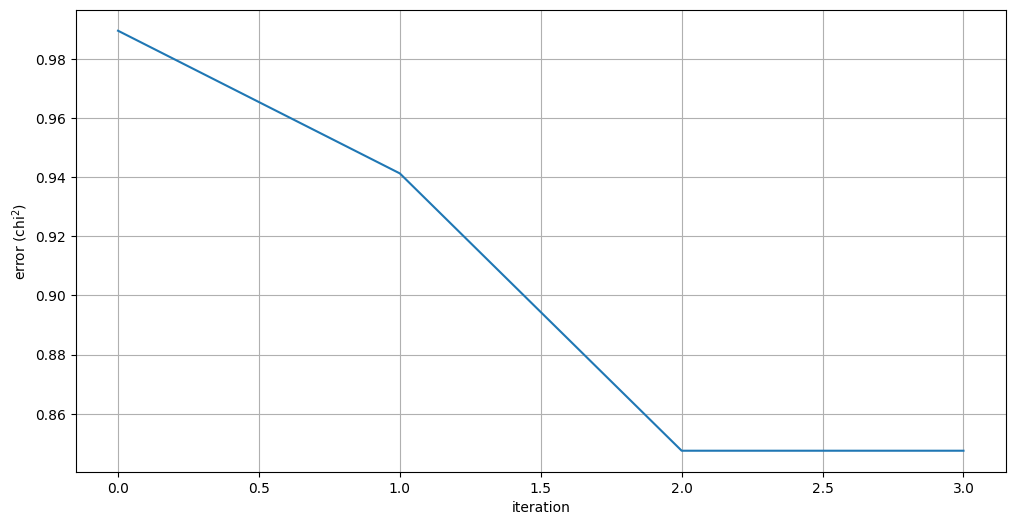

In [16]:
fig, axs = plt.subplots(figsize= (12,6))

axs.plot(scores)
axs.grid(True)
axs.set(ylabel= "error (chi$^2$)", xlabel= "iteration")

plt.show()

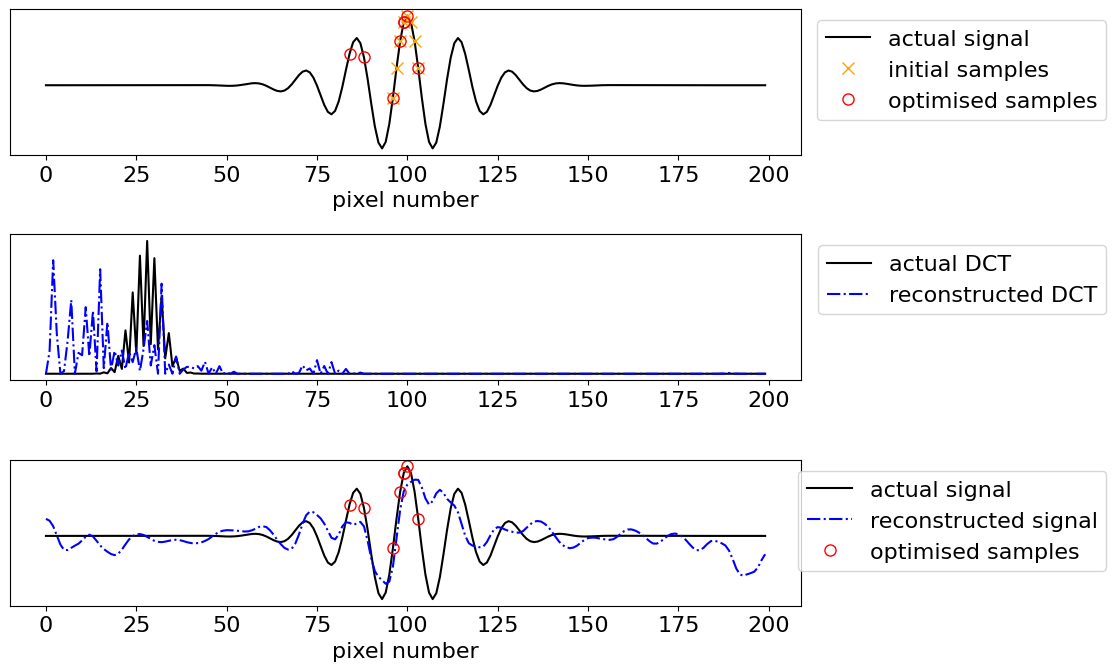

In [17]:
result_DCT = spfft.dct(result, norm= "forward")
target_DCT = spfft.dct(target, norm= "forward")


plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(initial_detectors, target[initial_detectors], marker= "x", markerfacecolor= "None", markersize= 8, color= "orange", linestyle= "None", label= "initial samples")
axs[0].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[0].set(xlabel= "pixel number")

axs[1].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[1].plot(np.abs(result_DCT), color= "blue", label= "reconstructed DCT", linestyle= "-.")

axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result, color= "blue", label= "reconstructed signal", linestyle= "-.")
axs[2].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right', bbox_to_anchor=(1.4, 1)) for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()

In [18]:
print(*np.sort(detectors), sep= ",")

84,88,96,98,99,99,100,103
